# Blind deconvolution

In [1]:
import sys
import os
# sys.path.insert(1, 'C:/Users/Johan/Documents/FAU_Masterarbeit/Implementation')
sys.path.insert(1, 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites')
#from deconv import REGISTRY
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
from matplotlib.colors import LogNorm
import imagequalitymetrics
import tifffile as tif
from scipy.signal import convolve
from skimage import io
from normalize import PercentileNormalizer, MinMaxNormalizer
from nutil.plot import paperStyle
import utils
import matplotlib as mpl

## PSF

In [31]:
psfs= 'C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/Blind_RL_Test/PSF_Check/'
conf = os.path.join(psfs, 'Confocal')
p2=os.path.join(psfs, '2P')
img = '11Alessandro_427_ArcCreERT2_Thy1GFP_Ai9_TRAP_2019-08-31_A2_psf.tif'
iqm = imagequalitymetrics.ImageQualityMetrics()

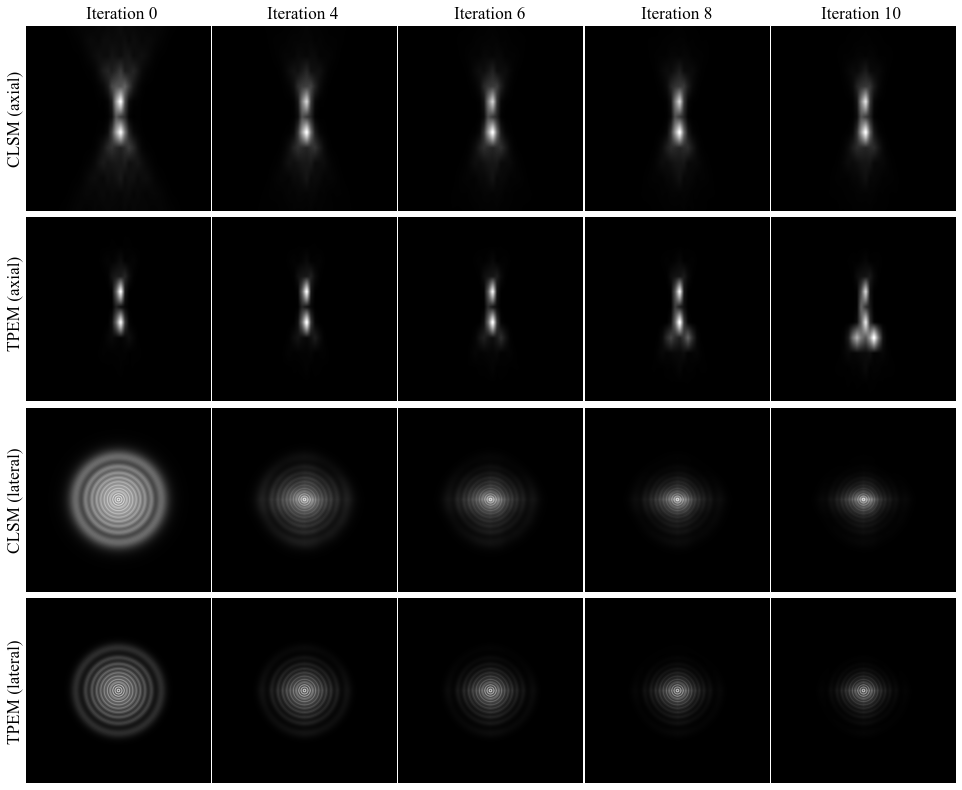

In [2]:
fig=plt.figure()
fig.set_figheight(14)
fig.set_figwidth(20)
plt.rcParams['font.family'] = 'Times New Roman'


n_h = 4
n_w = 6
plane=0
idxs=np.arange(0,11,2)
mse=np.zeros((10,1))
counter = 0
for (i,idx) in enumerate(idxs):
    if idx==2:
        pass
    else:
        psf1=utils.generate_axial_psf(os.path.join(conf, str(idx)+img))
        psf1 /=psf1.sum()

        ax = fig.add_subplot(n_h, n_w, counter+1)
        ax.imshow(psf1[150:322, 170:342],cmap='gray')
        ax.axis('off')
        if idx==0:
            ax.set_ylabel('Confocal')

        psf=utils.generate_axial_psf(os.path.join(p2, str(idx)+img))
        psf /=psf.sum()
        ax = fig.add_subplot(n_h, n_w, counter+7)
        ax.imshow(psf[150:322, 170:342],cmap='gray')
        if idx==0:
            ax.set_ylabel('2P')
        ax.axis('off')
        #############
        psf1=tif.imread(os.path.join(conf, str(idx)+img))
        psf1 = psf1[plane,:,:]
        psf1 /=psf1.sum()

        ax = fig.add_subplot(n_h, n_w, counter+13)
        ax.imshow(psf1,cmap='gray')
        ax.axis('off')

        psf=tif.imread(os.path.join(p2, str(idx)+img))
        psf /=psf.sum()

        psf = psf[plane,:,:]
        ax = fig.add_subplot(n_h, n_w, counter+19)
        ax.imshow(psf,cmap='gray')
        ax.axis('off')
        counter+=1
plt.text(-2120, -1210, 'CLSM (axial)', rotation=90, fontsize='xx-large')
plt.text(-2120, -700, 'TPEM (axial)', rotation=90, fontsize='xx-large')
plt.text(-2120, -140, 'CLSM (lateral)', rotation=90, fontsize='xx-large')
plt.text(-2120, 390, 'TPEM (lateral)', rotation=90, fontsize='xx-large')
plt.text(-1900, -1610, 'Iteration 0', fontsize='xx-large')
plt.text(-1400, -1610, 'Iteration 4', fontsize='xx-large')
plt.text(-880, -1610, 'Iteration 6', fontsize='xx-large')
plt.text(-360, -1610, 'Iteration 8', fontsize='xx-large')
plt.text(140, -1610, 'Iteration 10', fontsize='xx-large')

plt.subplots_adjust(wspace=0.01, hspace=0.01)
plt.savefig('psf_evolution.svg', bbox_inches='tight')
plt.savefig('psf_evolution.pdf', bbox_inches='tight')

In [3]:
plt.show()

In [32]:
mse=np.zeros((11,1))
norm = PercentileNormalizer()
for i in range(11):

    psf1=utils.generate_axial_psf(os.path.join(conf, str(i)+img))
    psf1 /=psf1.sum()

    psf=utils.generate_axial_psf(os.path.join(p2, str(i)+img))
    psf /=psf.sum()
    mse[i,0]=iqm.mse(psf1,psf)
    #mse[i,0]=iqm.mse(norm.normalize(psf1),norm.normalize(psf))

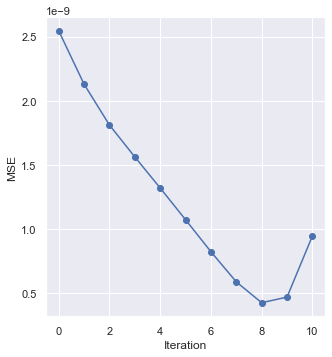

In [40]:
with paperStyle(12):
    mpl.rcParams['axes.titlesize'] = 20
    plt.rc('font', size=20) 
    #plt.rcParams['font.family'] = 'Times New Roman'
    sns.set(rc={'figure.figsize':(5,5.5)})

    #plt.grid()
    plt.plot(np.arange(0,11,1), mse, 'o-')
    plt.ylabel('MSE')
    plt.xlabel('Iteration')
plt.savefig('psf_evolution_mse.svg', bbox_inches='tight')
plt.savefig('psf_evolution_mse.pdf')

In [153]:
mse

array([[2.54388077e-09],
       [2.12790347e-09],
       [1.80989347e-09],
       [1.56163018e-09],
       [1.31938566e-09],
       [1.07243691e-09],
       [8.22969279e-10],
       [5.88080193e-10],
       [4.25785641e-10],
       [4.69517342e-10],
       [9.45814515e-10]])

## 0 Preprocessing: Denoising

Preprocessed images obtained in ./Denoising.ipynb

In [3]:
data_path = 'D:/jo77pihe/Registered/20220204_Denoising'
deconved_path ='D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing'
normalizer = PercentileNormalizer()
iqm = imagequalitymetrics.ImageQualityMetrics()

#### *Gaussian Smoothing*

Has Hyperparameter σ =[0.5,1,...,3.0] --> how does it effect the raw data? 

In [3]:
gauss_path = os.path.join(data_path, 'GaussianFilter')

#### *Neighbor2Neighbor*

Huang, Tao, et al. "Neighbor2Neighbor: Self-Supervised Denoising from Single Noisy Images." Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition. 2021.

In [4]:
n2n_path=os.path.join(data_path, 'Neighbor2Neighbor')

#### *Bilateral Filter*
C. Tomasi and R. Manduchi. 1998. Bilateral Filtering for Gray and Color Images. In: Proceedings of the Sixth International Conference on Computer Vision (ICCV ’98). IEEE Computer Society, Washington DC

In [5]:
bil_path = os.path.join(data_path, 'BilateralFilter')

## 1 Effect of denoising on deconvolution

### 1.1 Obtain results

No. iterations, empirically derived: 6,3,3

#### 1.1.1 Gaussian Smoothing

In [6]:
args = {}
args['data_path']= ''
args['source_folder']= gauss_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/Gaussian'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, 0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.2 Neighbor2Neighbor

In [7]:
args = {}
args['data_path']= ''
args['source_folder']= n2n_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/N2N'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.3 Bilateral Filter

In [8]:
args = {}
args['data_path']= ''
args['source_folder']= bil_path
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/Bilateral'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

#### 1.1.4 Ground truth (without denoising)

In [52]:
args = {}
args['data_path']= ''
args['source_folder']= os.path.join(data_path, 'Raw')
args['target_folder']= ''
args['psf'] = "../PSF"

args['result_path'] = 'D:/jo77pihe/Registered/20220211_Blind_RL/Preprocessing/NoPre'
blind_rl = REGISTRY['BlindRL'](args)
blind_rl.predict(args['source_folder'], 6, 3, 3, sigma=0.0, eval_img_steps = False, save_intermediate_res= True, parallel=True)

### 1.2 Evaluation

#### 1.2.1 Visual inspection

Tim_117_ArcCre_2017-05-08_A8.tif


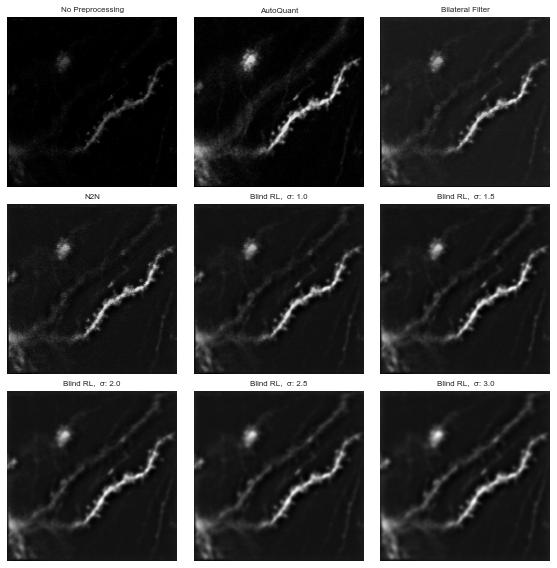

In [5]:
img1 = 'Tim_117_ArcCre_2017-05-08_A8.tif'
plane = 16
autoquant_res='D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
prefix = 'iter_3'
prefix2 = 'iter_2'

with paperStyle():
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)

    n_h = 3
    n_w = 3
    #Raw
    f = io.imread(os.path.join(deconved_path, 'NoPre', prefix2+img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('No Preprocessing')
    ax.axis('off')

    # AUtoQuant Img
    f = io.imread(os.path.join(autoquant_res, img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('AutoQuant')
    ax.axis('off')

    #bilateral img
    f = io.imread(os.path.join(deconved_path, 'Bilateral', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 3)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Bilateral Filter')
    ax.axis('off')

    # n2n Img
    f = io.imread(os.path.join(deconved_path, 'N2N', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 4)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('N2N')
    ax.axis('off')

    sm = ['1.0', '1.5', '2.0', '2.5', '3.0']
    for (i,l) in enumerate(sm):
        #Blind RL img
        f = io.imread(os.path.join(deconved_path,'Gaussian',prefix+l+'_'+img1))
        ax = fig.add_subplot(n_h, n_w, i+5)
        ax.imshow(f[plane, :, :],cmap='gray')
        ax.set_title('Blind RL,  σ: ' + l)
        ax.axis('off')

        plt.subplots_adjust(wspace=0.01, hspace=0.1)

plt.savefig('Deconv_preproc_visual_inspection.svg',bbox_inches='tight')
plt.savefig('Deconv_preproc_visual_inspection.pdf',bbox_inches='tight')

Tim_117_ArcCre_2017-05-08_A8.tif
0.0 24871.967


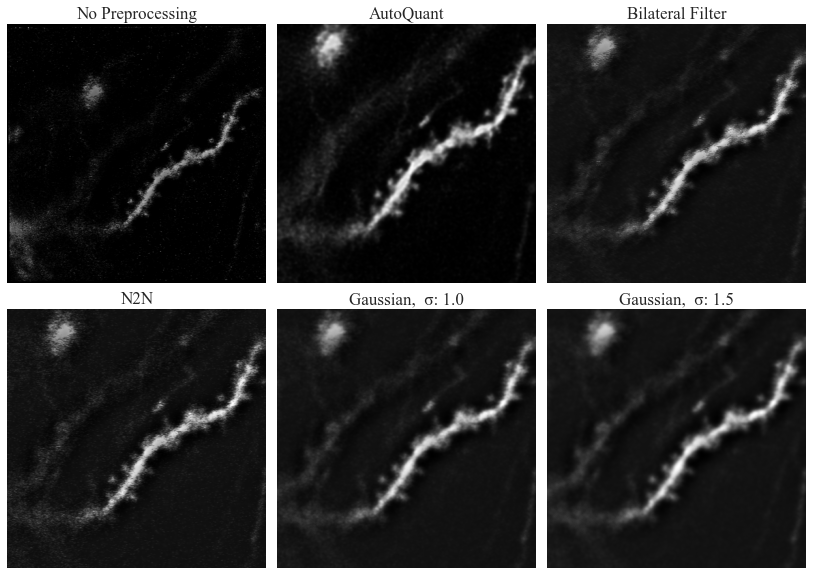

In [21]:
img1 = 'Tim_117_ArcCre_2017-05-08_A8.tif'
plane = 16
autoquant_res='D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
prefix = 'iter_3'
prefix2 = 'iter_2'

x_start=90
width = 380
y_start=100


with paperStyle():
    mpl.rcParams['axes.titlesize'] = 17
    plt.rcParams['font.family'] = 'Times New Roman'
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(14.5)

    n_h = 2
    n_w = 3
    #No Preprocessing
    f = io.imread(os.path.join(deconved_path, 'NoPre', prefix2+img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray', vmin = 0, vmax = 25000.996)
    ax.set_title('No Preprocessing')
    ax.axis('off')
    print(f[plane, :, :].min(), f[plane, y_start:(y_start+width), x_start:(x_start+width)].max())

    # AUtoQuant Img
    f = io.imread(os.path.join(autoquant_res, img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
    ax.set_title('AutoQuant')
    ax.axis('off')

    #bilateral img
    f = io.imread(os.path.join(deconved_path, 'Bilateral', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 3)
    ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
    ax.set_title('Bilateral Filter')
    ax.axis('off')

    # n2n Img
    f = io.imread(os.path.join(deconved_path, 'N2N', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 4)
    ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
    ax.set_title('N2N')
    ax.axis('off')

    sm = ['1.0', '1.5']
    for (i,l) in enumerate(sm):
        #Blind RL img
        f = io.imread(os.path.join(deconved_path,'Gaussian',prefix+l+'_'+img1))
        ax = fig.add_subplot(n_h, n_w, i+5)
        ax.imshow(f[plane, y_start:(y_start+width), x_start:(x_start+width)],cmap='gray')
        ax.set_title('Gaussian,  σ: ' + l)
        ax.axis('off')

        plt.subplots_adjust(wspace=0.005, hspace=0.1)

plt.savefig('Deconv_preproc_visual_inspection.svg',bbox_inches='tight')
plt.savefig('Deconv_preproc_visual_inspection.pdf',bbox_inches='tight')

Tim_117_ArcCre_2017-05-08_A8.tif


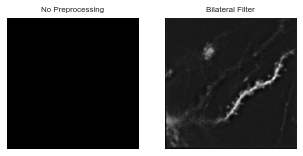

In [5]:
img1 = 'Tim_117_ArcCre_2017-05-08_A8.tif'
plane = 16
autoquant_res='D:/jo77pihe/Registered/20220203_AutoQuant_Averaged'
prefix = 'iter_4'
prefix2 = 'iter_4'

with paperStyle():
    print("\033[1m" + img1 + "\033[0m")
    fig=plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)

    n_h = 1
    n_w = 2
    #Raw
    f = io.imread(os.path.join(deconved_path, 'NoPre', prefix2+img1))
    ax = fig.add_subplot(n_h, n_w, 1)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('No Preprocessing')
    ax.axis('off')

    #bilateral img
    f = io.imread(os.path.join(deconved_path, 'Bilateral', prefix+img1))
    ax = fig.add_subplot(n_h, n_w, 2)
    ax.imshow(f[plane, :, :],cmap='gray')
    ax.set_title('Bilateral Filter')
    ax.axis('off')
plt.savefig('Deconv_preproc_vanishing.svg', bbox_inches='tight')
plt.savefig('Deconv_preproc_vanishing.pdf',bbox_inches='tight')

#### 1.2.2 Quantitative evaluation: SNR

*SNR*

In [25]:
path = deconved_path
bil_path = 'Bilateral'
gaussian = 'Gaussian'
n2n_path = 'N2N'
raw= 'NoPre'
sigma15 = '1.5_'
sigma1 = '1.0_'


files = [f for f in os.listdir(os.path.join(data_path, 'BilateralFilter')) if f.endswith('.tif')]

res = np.zeros((len(files)*5,2))
labels= []

for (i,file) in enumerate(files):
    p_raw_n= io.imread(os.path.join(data_path,'Raw', file))
    p_raw_n = normalizer.normalize(p_raw_n)
    p_bil=io.imread(os.path.join(path,bil_path, 'iter_3'+file))
    p_bil = normalizer.normalize(p_bil)
    p_gau1=io.imread(os.path.join(path,gaussian,'iter_3'+sigma1+file))
    p_gau1 = normalizer.normalize(p_gau1)
    p_gau=io.imread(os.path.join(path,gaussian,'iter_3'+sigma15+file))
    p_gau = normalizer.normalize(p_gau)
    p_n2n=io.imread(os.path.join(path,n2n_path, 'iter_3'+file))
    p_n2n = normalizer.normalize(p_n2n)
    p_raw= io.imread(os.path.join(path,raw, 'iter_3'+file))
    p_raw = normalizer.normalize(p_raw)
    
    snr_x = iqm.snr(p_raw_n)
    res[i*5,:] =[snr_x,iqm.snr(p_raw)]
    labels.append('No PreProc')
    res[i*5+1,:] =[snr_x,iqm.snr(p_bil)]
    labels.append('Bilateral')
    res[i*5+2,:] =[snr_x,iqm.snr(p_gau1)]
    labels.append('Gaussian, σ: '+str(sigma1)[:-1])
    res[i*5+3,:] =[snr_x,iqm.snr(p_gau)]
    labels.append('Gaussian, σ: '+str(sigma15)[:-1])
    res[i*5+4,:] =[snr_x,iqm.snr(p_n2n)]
    labels.append('N2N')


In [26]:
import pandas as pd

df = pd.DataFrame(res, columns=['Raw', 'Deconvolved'])
df['Denoiser'] = labels

In [27]:
df.to_pickle('deconv_preproc_snr.pkl')

In [28]:
df = pd.read_pickle('deconv_preproc_snr.pkl')

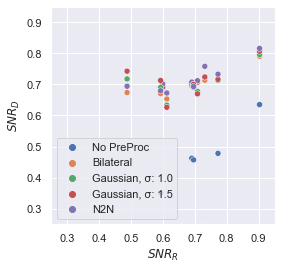

In [29]:
with paperStyle():
    sns.set(rc={'figure.figsize':(4,4)})
    p=sns.scatterplot(data=df, x="Raw", y="Deconvolved", hue="Denoiser")
    p.legend(loc='lower left')
    #p.legend(loc='center left', bbox_to_anchor=(1, 0.8), ncol=1)
    plt.title('SNR')
    plt.xlim(0.25,0.95)
    plt.ylim(0.25,0.95)
    plt.xlabel('$SNR_{R}$')
    plt.ylabel('$SNR_{D}$')
    plt.title('')
plt.savefig('Deconv_snr.svg',bbox_inches='tight')
plt.savefig('Deconv_snr.pdf',bbox_inches='tight')

#### 1.2.2.3 Quantitative evaluation: Reconstruction Error

In [31]:
deconvolver = REGISTRY['BlindRL'](args)
def calc(preprocessed_path, deconved_path, f, gauss= False):
    if gauss:
        it= 'iter_3'
    else:
        it='333'
    preprocessed = tif.imread(os.path.join(preprocessed_path, f))
    preprocessed = normalizer.normalize(preprocessed)

    img = tif.imread(os.path.join(deconved_path,it+f))
    psf = tif.imread(os.path.join(deconved_path, it+f[:-4]+'_psf.tif'))
    psf = deconvolver._pad(psf)
    img = deconvolver._pad(img)
    convolved = convolve(img, psf, mode='same')
    convolved = deconvolver._unpad(convolved)
    convolved = normalizer.normalize(convolved)
    return preprocessed, convolved

In [33]:
sigma = '1.5_'
sigma1='1.0_'
# PSNR, SSIM, MSE
files = [f for f in os.listdir(os.path.join(data_path, 'BilateralFilter')) if (f.endswith('.tif') and (not 'psf' in f))]

result = np.zeros((len(files)*5,3))
labels = []
for (j,f) in enumerate(files):
    # Bil filter
    preprocessed, convolved = calc(os.path.join(data_path, 'BilateralFilter'), 
                                   os.path.join(deconved_path, 'Bilateral'), f)
    result[j*5,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]   
    labels.append('Bilateral')

    # Bil filter
    preprocessed, convolved = calc(os.path.join(data_path, 'Neighbor2Neighbor'), 
                                   os.path.join(deconved_path, 'N2N'), f)
    result[j*5+1,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]  
    labels.append('N2N')
    
    # Gaussian
    preprocessed, convolved = calc(os.path.join(data_path, 'GaussianFilter'), 
                                   os.path.join(deconved_path, 'Gaussian'), sigma1+f, gauss=True)
    result[j*5+2,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]
    labels.append('Gaussian,\n σ: '+str(sigma1)[:-1])
    
    # Gaussian
    preprocessed, convolved = calc(os.path.join(data_path, 'GaussianFilter'), 
                                   os.path.join(deconved_path, 'Gaussian'), sigma+f, gauss=True)
    result[j*5+3,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]
    labels.append('Gaussian,\n σ: '+str(sigma)[:-1])
    
    preprocessed, convolved = calc(os.path.join(data_path, 'Raw'), 
                                   os.path.join(deconved_path, 'NoPre'), f)
    result[j*5+4,:] = [iqm.psnr(preprocessed, convolved), iqm.ssim(preprocessed, convolved),
                    iqm.mse(preprocessed, convolved)]
    labels.append('No Pre')

In [50]:
sigma = '1.5_'
sigma1='1.0_'
# PSNR, SSIM, MSE
files = [f for f in os.listdir(os.path.join(data_path, 'BilateralFilter')) if (f.endswith('.tif') and (not 'psf' in f))]

labels = []
for (j,f) in enumerate(files):
    # Bil filter

    labels.append('Bilateral')


    labels.append('N2N')
    

    labels.append('Gaussian,\n σ: '+str(sigma1)[:-1])

    labels.append('Gaussian,\n σ: '+str(sigma)[:-1])

    labels.append('No Pre')

In [51]:
import pandas as pd

df = pd.DataFrame(result, columns=['PSNR', 'SSIM', 'MSE'])
df['Denoiser'] = labels

In [52]:
df

,PSNR,SSIM,MSE,Denoiser
0,109.320003,0.780802,1.382883,Bilateral
1,101.592699,0.212542,8.194375,N2N
2,111.249097,0.861291,0.886903,"Gaussian,\n σ: 1.0"
3,111.193850,0.876514,0.898257,"Gaussian,\n σ: 1.5"
4,103.556270,0.391348,5.213852,No Pre
5,110.561674,0.820500,1.039007,Bilateral
6,100.226548,0.236636,11.223567,N2N
7,112.352994,0.898243,0.687838,"Gaussian,\n σ: 1.0"
8,112.625081,0.916977,0.646067,"Gaussian,\n σ: 1.5"
9,107.629350,0.553192,2.041036,No Pre


In [45]:
df.to_pickle('blind_rl_reconstruction_errorx.pkl')

In [15]:
import pandas as pd
df=pd.read_pickle('blind_rl_reconstruction_errorx.pkl')


In [19]:
df=df.replace('No Preproc', 'No Pre')
df = df.replace('Gaussian, σ: 1.0','Gaussian,\n σ: 1.0')
df = df.replace('Gaussian, σ: 1.5','Gaussian,\n σ: 1.5')

In [26]:
np_ssim=np.array(df['SSIM'])

In [36]:
np.mean(np_ssim[0::5])

0.711584906619292

In [34]:
np.mean(np_ssim[1::5])

0.23442469312681333

#### PSNR

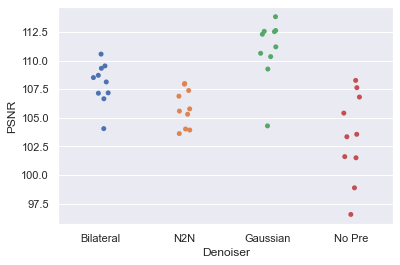

In [7]:
sns.set()
ax = sns.stripplot(x="Denoiser", y="PSNR", data=df)

*SSIM*

(0.0, 1.0)

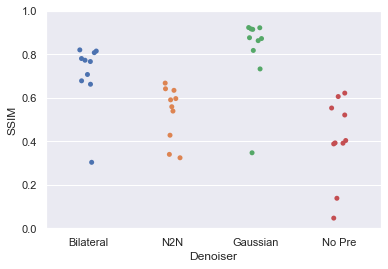

In [8]:
sns.set()
ax = sns.stripplot(x="Denoiser", y="SSIM", data=df, jitter=0.1)
ax.set_ylim(0,1)

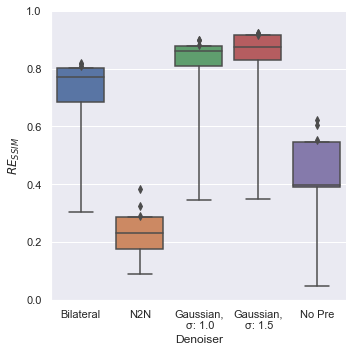

In [20]:
with paperStyle():
    sns.set(rc={'figure.figsize':(15,4)})
    ax=sns.catplot(x="Denoiser", y="SSIM", kind="box", data=df, whis=[0,1])
    ax.set(ylim=(0, 1), ylabel='$RE_{SSIM}$')
plt.savefig('blind_rl_reconstruction_error.svg',bbox_inches='tight')
plt.savefig('blind_rl_reconstruction_error.pdf',bbox_inches='tight')

*MSE*


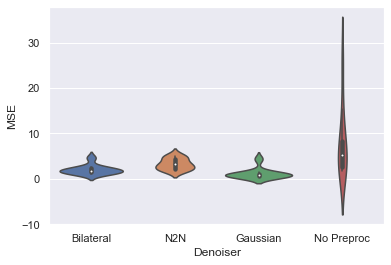

In [99]:
ax = sns.violinplot(x="Denoiser", y="MSE", data=df)

# 2. Find best Hyperparameters

### 2.1 Evaluate all hyperparameter combinations

Evaluate BL with number of inner loop iterations *i_psf, i_img = [1,....,5]* and outer iterations *i_rl = [1,...,10]*

#### 2.1.1 Obtain results

In [2]:
args = {}
args['data_path']= ''
args['source_folder']= 'D:\\jo77pihe\Registered\\20220203_AutoQuant_NotAveraged\\Blind_rl\\Raw'
args['target_folder']= ''
args['result_path'] = 'D:\\jo77pihe\\Registered\\20220215_Blind_RL_HypTuning_Sigma1'
args['psf'] = "C:/Users/jo77pihe/Documents/MasterThesis_OfSpinesAndDendrites/PSF"

max_iter_inner = 5
max_iter_outer = 10
sigma = 1.0

In [4]:
blind_rl = REGISTRY['BlindRL'](args)

In [5]:
for i_psf in range(1,max_iter_inner+1):
    for i_img in range(1,max_iter_inner+1):
        blind_rl.predict(args['source_folder'], max_iter_outer, i_img, i_psf, sigma, eval_img_steps = True, save_intermediate_res = True)

*Create data structure with all results*

In [6]:
from skimage.filters import gaussian

def preprocess(img, sigma=1):
    img = gaussian(img, sigma=sigma)
    return img

def _pad(img, pixels=10, planes=5):
    """
    Pad image
    :param img: Original image (np.array)
    :param pixels: amount to pad in x and y direction
    :param planes: amount to pad in z direction
    :return: padded image
    """
    return np.pad(img, ((planes, planes), (pixels, pixels), (pixels, pixels)), 'reflect')

def _unpad(img, pixels=10, planes=5):
    '''
    Crop the image by the number of pixels specified in x and y direction, by the amount of planes in z direction.
    :param img: Input image
    :param pixels: Image is reduced by the number of pixels specified in x and y direction on both sides
    :param planes: Image is reduced by the number of planes specified in z direction on both sides
    :return: Cropped image
    '''

    pixels = int(pixels)
    planes = int(planes)
    (z, x, y) = img.shape
    return img[planes:z - planes, pixels:x - pixels, pixels:y - pixels]

In [7]:
sig = 1.0
iter_rl= np.tile(np.repeat(np.arange(1,max_iter_outer+1), (max_iter_inner)), max_iter_inner)
iter_img= np.tile(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)
iter_psf= np.repeat(np.arange(1,max_iter_inner+1), max_iter_inner*max_iter_outer)

original_path = '..\\Registered\\Heatmap_reduced'
res_path = 'D:\\jo77pihe\\Registered\\Blind_RL_Heatmap'

files = [f for f in os.listdir(original_path) if f.endswith('.tif') and (not 'psf' in f)]

In [8]:
lx = len(iter_rl)
df = pd.DataFrame()
df['Iter_RL'] = iter_rl#np.tile(iter_rl, len(files))
df['Iter_IMG'] = iter_img#np.tile(iter_img, len(files))
df['Iter_PSF'] = iter_psf#np.tile(iter_psf, len(files))
# names =  [f for f in files for i in range(lx)]
# df['File'] = names

df['psnr'] = np.zeros((len(df),1))
df['ssim'] = np.zeros((len(df),1))
df['mse'] = np.zeros((len(df),1))

for idx in range(0,len(df)):
    psnr = 0
    ssim = 0
    mse=0
    for fx in files:
        f = str(iter_rl[idx])+str(iter_psf[idx])+str(iter_img[idx])+ str(fx)
        img = np.float32(io.imread(os.path.join(res_path, f)))
        psf = np.float32(io.imread(os.path.join(res_path, f[:-4]+'_psf.tif')))

        org = np.float32(io.imread(os.path.join(original_path, fx)))
        org_sm = preprocess(org, sig)
        
        psf = _pad(psf)
        img = _pad(img)
        convolved = convolve(img, psf, mode='same')
        convolved =_unpad(convolved)

        # Scaling
        org_sm = normalizer.normalize(org_sm)
        convolved = normalizer.normalize(convolved)
        
        psnr += iqm.psnr(org_sm, convolved)
        ssim += iqm.ssim(org_sm, convolved)
        mse += iqm.mse(org_sm, convolved)

    df.loc[[idx],['psnr']]= psnr/len(files)
    df.loc[[idx],['ssim']]= ssim/len(files)
    df.loc[[idx],['mse']]= mse/len(files)
    print(idx)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [9]:
df.to_pickle("heatmap_1.pkl")

In [2]:
#df=pd.read_pickle('heatmap_1.pkl')
df=pd.read_pickle('heatmap.pkl')
df=df.rename(columns={"Iter_IMG": "$I_{IMG}$", "Iter_PSF": "$I_{PSF}$"})

In [12]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(df)

     Iter_RL  $I_{IMG}$  $I_{PSF}$        psnr      ssim           mse
0          1          1          1   93.471658  0.230933  5.368696e+01
1          1          2          1   96.289674  0.340493  2.837813e+01
2          1          3          1   98.125685  0.418599  1.862341e+01
3          1          4          1   99.521734  0.477376  1.347694e+01
4          1          5          1  100.642003  0.522702  1.038603e+01
5          2          1          1   98.354518  0.434165  1.792166e+01
6          2          2          1  102.609987  0.622359  6.884577e+00
7          2          3          1  105.335774  0.720210  3.734378e+00
8          2          4          1  107.296130  0.777324  2.424364e+00
9          2          5          1  108.720625  0.812763  1.772050e+00
10         3          1          1  103.110709  0.657539  6.200236e+00
11         3          2          1  108.638312  0.831158  1.833848e+00
12         3          3          1  111.706641  0.889798  9.276743e-01
13    

#### 2.1.2 Plot result

C:\Users\jo77pihe\.conda\envs\ma\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


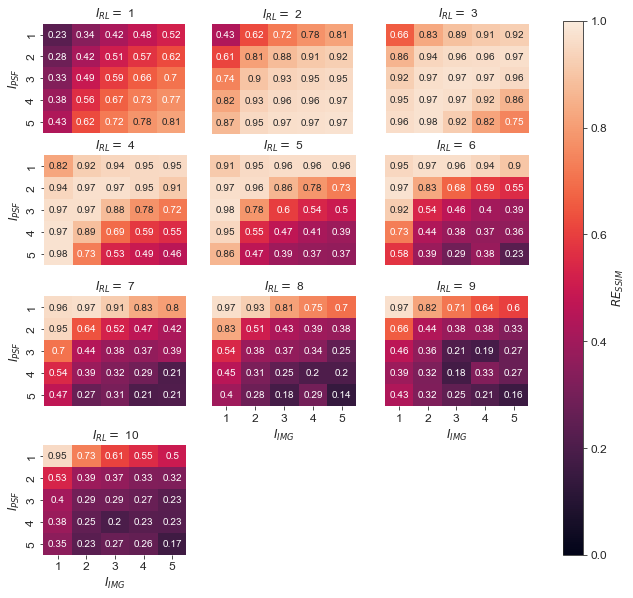

In [13]:
max_iter_outer=10
with paperStyle():
    fig = plt.figure()
    vmin = 0
    vmax = 1
    #sns.set(font_scale=1.1)

    for i in range(max_iter_outer):
        ax = fig.add_subplot(4, 3, i+1)
        df_i = df.loc[df['Iter_RL'] == i+1]
        # df_sub = df_i.iloc[i*(max_iter_inner**2): (i+1)*(max_iter_inner**2)]
        df_i.drop(columns='Iter_RL', inplace=True)
        # r = np.reshape(np.array(df_sub['snr'], (max_iter_inner, max_iter_inner))
        df_pivot = df_i.pivot("$I_{PSF}$", "$I_{IMG}$", "ssim")
        # df_pivot = df_i.groupby(['Iter_IMG', 'Iter_PSF']).mean().unstack(level=0)
        if i == 5:
            sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, cbar=True,
                        cbar_kws = dict(use_gridspec=False, pad=0.01, shrink=2.25),
                        xticklabels=False,
                        yticklabels=False, annot=True)
            cbar_kws = dict(use_gridspec=False, location="bottom", pad=0.01, shrink=0.25)

        else:
            res=sns.heatmap(df_pivot, vmin=vmin, vmax=vmax, cbar=False, yticklabels=True if i%3==0 else False,
                        xticklabels=True if i ==9 or i == 7 or i == 8 else False, annot=True)
            if len(res.get_ymajorticklabels())>0:
                res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 12)
                res.set_ylabel("$I_{PSF}$",fontsize=12)
            if len(res.get_xmajorticklabels())>0:
                res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 12)
                res.set_xlabel("$I_{IMG}$",fontsize=12)

        ax.set_title('$I_{RL} =$ ' +str(i+1))
        atx = ax
    ax = fig.add_subplot(4, 3, 12)
    #cbar = atx.collections[0].colorbar
    #cbar.tick_params(labelsize=20)

    cb=fig.colorbar(atx.collections[0], cax=ax)
    cb.set_label(label='$RE_{SSIM}$', size=12, weight='bold') #, rotation=0)
    #cb.ax.set_title('$RE_{SSIM}$', size=12)
    ax.tick_params(labelsize=12)
# here set the labelsize by 20

    #% start: automatic generated code from pylustrator
    plt.figure(1).ax_dict = {ax.get_label(): ax for ax in plt.figure(1).axes}
    import matplotlib as mpl
    plt.figure(1).set_size_inches(25.230000/2.54, 23.090000/2.54, forward=True)
    plt.figure(1).ax_dict["<colorbar>"].set_visible(False)
    plt.figure(1).axes[0].set_position([0.125000, 0.712609, 0.198356, 0.167391])
    plt.figure(1).axes[0].title.set_fontsize(12)
    plt.figure(1).axes[0].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[1].set_position([0.360623, 0.711598, 0.197432, 0.167391])
    plt.figure(1).axes[1].title.set_fontsize(12)
    plt.figure(1).axes[1].title.set_position([0.500000, 1.006035])
    plt.figure(1).axes[1].xaxis.labelpad = -5.440000
    plt.figure(1).axes[1].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[1].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[2].set_position([0.603643, 0.712609, 0.200205, 0.167391])
    plt.figure(1).axes[2].title.set_fontsize(12)
    plt.figure(1).axes[2].title.set_position([0.504618, 1.000000])
    plt.figure(1).axes[2].yaxis.labelpad = -4.720000
    plt.figure(1).axes[2].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[2].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[3].set_position([0.125925, 0.511739, 0.200205, 0.167391])
    plt.figure(1).axes[3].title.set_fontsize(12)
    plt.figure(1).axes[3].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[4].set_position([0.358775, 0.511739, 0.203903, 0.167391])
    plt.figure(1).axes[4].spines['right'].set_visible(False)
    plt.figure(1).axes[4].spines['top'].set_visible(False)
    plt.figure(1).axes[4].title.set_fontsize(12)
    plt.figure(1).axes[4].yaxis.labelpad = -4.000000
    plt.figure(1).axes[4].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[4].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[5].set_position([0.602305, 0.511739, 0.201543, 0.167391])
    plt.figure(1).axes[5].title.set_fontsize(12)
    plt.figure(1).axes[5].xaxis.labelpad = -4.720000
    plt.figure(1).axes[5].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[5].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[7].set_position([0.125925, 0.295716, 0.199281, 0.167391])
    plt.figure(1).axes[7].title.set_fontsize(12)
    plt.figure(1).axes[7].title.set_position([0.500000, 0.987930])
    plt.figure(1).axes[7].xaxis.labelpad = -4.720000
    plt.figure(1).axes[7].get_xaxis().get_label().set_visible(False)
    plt.figure(1).axes[8].set_position([0.360623, 0.295716, 0.202055, 0.167391])
    plt.figure(1).axes[8].title.set_position([0.500000, 1.000000])
    plt.figure(1).axes[8].title.set_fontsize(12)
    plt.figure(1).axes[8].title.set_position([0.504549, 0.993978])
    plt.figure(1).axes[8].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[9].set_position([0.602305, 0.295716, 0.200205, 0.167391])
    plt.figure(1).axes[9].title.set_fontsize(12)
    plt.figure(1).axes[9].get_yaxis().get_label().set_visible(False)
    plt.figure(1).axes[10].set_position([0.125000, 0.068586, 0.200205, 0.167391])
    plt.figure(1).axes[10].title.set_fontsize(12)
    plt.figure(1).axes[10].title.set_position([0.504618, 1.000000])
    plt.figure(1).axes[11].set_position([0.851144, 0.068315, 0.029166, 0.815951])
    #% end: automatic generated code from pylustrator
    plt.savefig('Heatmap_var_params.svg', bbox_inches='tight')
    plt.savefig('Heatmap_var_params.pdf', bbox_inches='tight')
